In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.sparse as sp
import matplotlib.pyplot as pl
import random
# import scanpy.plotting
# import rpy2.robjects as robjects
# from rpy2.robjects import pandas2ri

# import sklearn as sk
import pandas as pd
import numpy as np
import pathlib as pl

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax.example_libraries.optimizers import adam

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import zero_one_loss
from collections import Counter

import os
import sys
os.chdir("D:\OneDrive\OneDrive - UW-Madison\Kris\Code\curatedMetagenomicDataAnalyses\\vignettes")
# os.chdir("C:\OneDrive\OneDrive - UW-Madison\Kris\Code\curatedMetagenomicDataAnalyses\\vignettes")
import gc

# visualizations
import plotly.express as px
import plotly.offline as pyo
import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

custom_colors = ["#a8e6cf","#dcedc1","#ffd3b6","#ffaaa5","#ff8b94"]
palette = sns.set_palette(sns.color_palette(custom_colors))
FP_CRC_META = os.path.join("crc_meta.csv")
FP_CRC_SEPARATE = os.path.join("crc_separate_taxon.csv")
FP_CRC_WHOLE = os.path.join("crc_whole_taxon.csv")
FP_CRC_MAT = os.path.join("crc_mat.csv")

In [2]:
crc_meta = pd.read_csv(FP_CRC_META)
crc_sepa = pd.read_csv(FP_CRC_SEPARATE)
crc_whole = pd.read_csv(FP_CRC_WHOLE)
crc_data = crc_sepa.iloc[7:, 3:]
crc_data = crc_data.astype(float)

crc_sepa.rename(columns={'Unnamed: 0': 'observations'}, inplace=True)

d:\Anaconda\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning:

Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,2

# Dataset Overview

## Data value overview

In [3]:
crc_whole

,observations,study_name,study_condition,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium|s__Faecalibacterium_prausnitzii,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus|s__Streptococcus_salivarius,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Anaerostipes|s__Anaerostipes_hadrus,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_stercoris,k__Bacteria|p__Actinobacteria|c__Coriobacteriia|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella|s__Collinsella_aerofaciens,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium|s__Bifidobacterium_longum,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_plebeius,...,k__Eukaryota|p__Ascomycota|c__Saccharomycetes|o__Saccharomycetales|f__Debaryomycetaceae|g__Candida|s__Candida_tropicalis,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella|s__Weissella_hellenica,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_vitulinus,k__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Campylobacteraceae|g__Campylobacter|s__Campylobacter_coli,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_striatum,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Corynebacteriales|f__Corynebacteriaceae|g__Corynebacterium|s__Corynebacterium_pseudodiphtheriticum,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_crustorum,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_farciminis,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Klebsiella|s__Klebsiella_quasivariicola,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinobaculum|s__Actinobaculum_massiliense
0,SID31004,FengQ_2015,CRC,5557520,4501905,3379283,2134734,1875111,1600270,1543442,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,SID31009,FengQ_2015,control,3426422,91870,4992315,0,2436224,1566408,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SID31021,FengQ_2015,control,3703353,106369,5022513,7228,1626225,2537241,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SID31030,FengQ_2015,adenoma,1407572,78931,540874,300730,1104594,491720,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SID31071,FengQ_2015,control,6735145,136315,1595369,33915,4128586,3397989,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645,CCIS95409808ST.4.0,ZellerG_2014,control,1021983,186876,643569,32664,1199899,793182,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7950.0
1646,CCIS96387239ST.4.0,ZellerG_2014,adenoma,2306131,22790,21378,327276,781411,397046,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1647,CCIS98482370ST.3.0,ZellerG_2014,control,1795756,6503,701544,3724477,20806,12635,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1648,CCIS98512455ST.4.0,ZellerG_2014,CRC,1615860,191933,328142,2138003,90401,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
crc_data.values

array([[5.557520e+06, 4.501905e+06, 3.379283e+06, ...,          nan,
                 nan,          nan],
       [3.426422e+06, 9.187000e+04, 4.992315e+06, ...,          nan,
                 nan,          nan],
       [3.703353e+06, 1.063690e+05, 5.022513e+06, ...,          nan,
                 nan,          nan],
       ...,
       [1.795756e+06, 6.503000e+03, 7.015440e+05, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.615860e+06, 1.919330e+05, 3.281420e+05, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [5.390451e+06, 4.990000e+03, 1.401648e+06, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])

In [25]:
study_names = np.unique(crc_whole.study_name)

In [26]:
study_names

array(['FengQ_2015', 'GuptaA_2019', 'HanniganGD_2017', 'ThomasAM_2018a',
       'ThomasAM_2018b', 'ThomasAM_2019_c', 'VogtmannE_2016',
       'WirbelJ_2018', 'YachidaS_2019', 'YuJ_2015', 'ZellerG_2014'],
      dtype=object)

In [3]:
# Number of observations per study
Counter(crc_whole.iloc[:,1])

Counter({'FengQ_2015': 154,
         'GuptaA_2019': 60,
         'HanniganGD_2017': 81,
         'ThomasAM_2018a': 80,
         'ThomasAM_2018b': 60,
         'ThomasAM_2019_c': 80,
         'VogtmannE_2016': 110,
         'WirbelJ_2018': 125,
         'YachidaS_2019': 616,
         'YuJ_2015': 128,
         'ZellerG_2014': 156})

In [69]:
# compute not-all-zero species for each study 
valid_species = dict()
for name in study_names:
    X_study = crc_whole[crc_whole['study_name']==name].iloc[:,3:]
    # print(X_study)
    species = X_study.columns[(X_study != 0).any()]
    valid_species[name] = species

In [72]:
print([len(value) for value in valid_species.values()])

[935, 935, 935, 935, 935, 935, 935, 935, 935, 935, 935]


In [71]:
for key in valid_species:
    print(f'{key} has {len(valid_species[key])}')

FengQ_2015 has 935
GuptaA_2019 has 935
HanniganGD_2017 has 935
ThomasAM_2018a has 935
ThomasAM_2018b has 935
ThomasAM_2019_c has 935
VogtmannE_2016 has 935
WirbelJ_2018 has 935
YachidaS_2019 has 935
YuJ_2015 has 935
ZellerG_2014 has 935


## Overview plotting

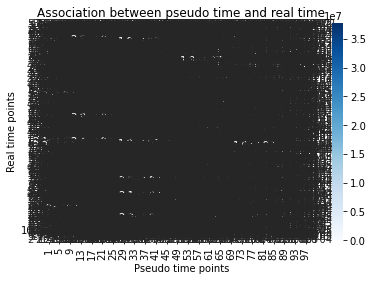

In [6]:
# Create a heatmap
# sns.heatmap(crc_data, annot=True, fmt='d', cmap='Blues')
sns.heatmap(crc_data.iloc[:100,:100], annot=True, cmap='Blues')

# Add labels and title
plt.xlabel('Pseudo time points')
plt.ylabel('Real time points')
plt.title('Association between pseudo time and real time')

# Display the plot
plt.show()

In [50]:
X = crc_data.values
y = crc_whole['study_name'] == "CRC"

In [20]:
y

0       False
1       False
2       False
3       False
4       False
        ...  
1645    False
1646    False
1647    False
1648    False
1649    False
Name: study_name, Length: 1650, dtype: bool

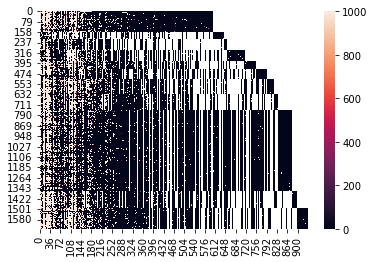

In [22]:
sns.heatmap(X, vmax=1000)

# Display the heatmap
plt.show()

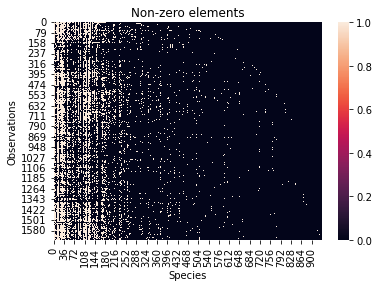

In [37]:
sns.heatmap(X > 0)
plt.xlabel('Species')
plt.ylabel('Observations')
plt.title('Non-zero elements')
plt.show()

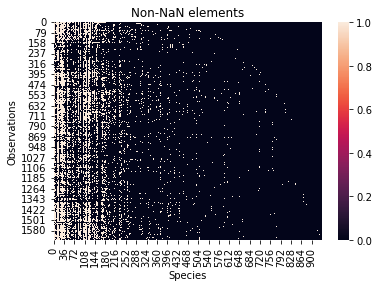

In [36]:
sns.heatmap(np.logical_and(~np.isnan(X), X != 0))
plt.xlabel('Species')
plt.ylabel('Observations')
plt.title('Non-NaN elements')
plt.show()

In [52]:
np.mean(X>0)

0.10142991411440609

In [51]:
1-np.mean(np.isnan(X))

0.6413488899692108

In [39]:
X[np.isnan(X)] = 0.0

d:\Anaconda\Anaconda3\lib\site-packages\numpy\lib\histograms.py:905: RuntimeWarning:

invalid value encountered in true_divide



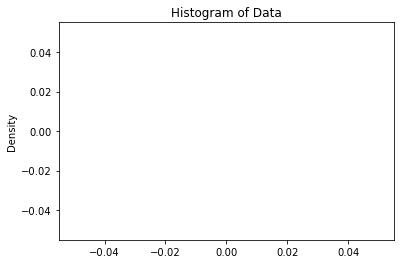

In [53]:
sns.histplot(data=X.reshape(-1), binwidth=0.1, binrange=[0.1, 5], stat="density")
plt.title("Histogram of Data")
# plt.xlabel("X-axis Label")
# plt.ylabel("Y-axis Label")
plt.show()

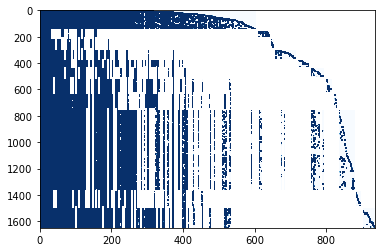

In [54]:
plt.imshow(X, cmap='Blues', aspect='auto', vmin=0, vmax=1)

# Masked Imputation

In [19]:
study_names = np.unique(crc_whole.study_name)
study_names

array(['FengQ_2015', 'GuptaA_2019', 'HanniganGD_2017', 'ThomasAM_2018a',
       'ThomasAM_2018b', 'ThomasAM_2019_c', 'VogtmannE_2016',
       'WirbelJ_2018', 'YachidaS_2019', 'YuJ_2015', 'ZellerG_2014'],
      dtype=object)

In [22]:
selected_study_names = [study_names[0], study_names[10]]
selected_data = crc_whole[crc_whole['study_name'].isin(selected_study_names)]

In [51]:
selected_data.dropna(axis=1, how='all', inplace=True)

C:\Users\ysc12\AppData\Local\Temp\ipykernel_86000\729603666.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [76]:
X1 = selected_data[selected_data['study_name']==selected_study_names[0]]
X2 = selected_data[selected_data['study_name']==selected_study_names[1]]

X = selected_data.iloc[:,3:]
X1 = X1.iloc[:, 3:]
X2 = X2.iloc[:, 3:]

In [77]:
nancol_2 = X2.columns[~X2.isna().all()]


In [79]:
X = X[nancol_2]
X1 = X1[nancol_2]
X2 = X2[nancol_2]

In [78]:
len(nancol_2)

652

In [53]:
X

array([[5.557520e+06, 4.501905e+06, 3.379283e+06, ...,          nan,
                 nan,          nan],
       [3.426422e+06, 9.187000e+04, 4.992315e+06, ...,          nan,
                 nan,          nan],
       [3.703353e+06, 1.063690e+05, 5.022513e+06, ...,          nan,
                 nan,          nan],
       ...,
       [1.795756e+06, 6.503000e+03, 7.015440e+05, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [1.615860e+06, 1.919330e+05, 3.281420e+05, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00],
       [5.390451e+06, 4.990000e+03, 1.401648e+06, ..., 0.000000e+00,
        0.000000e+00, 0.000000e+00]])

<Axes: >

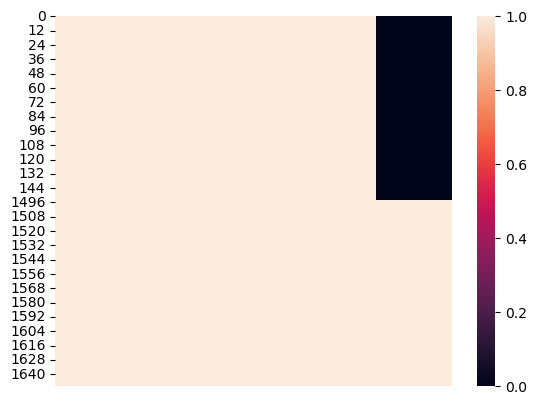

In [81]:
sns.heatmap(~np.isnan(X), xticklabels=False)

In [84]:
X2.shape

(156, 652)

<Axes: >

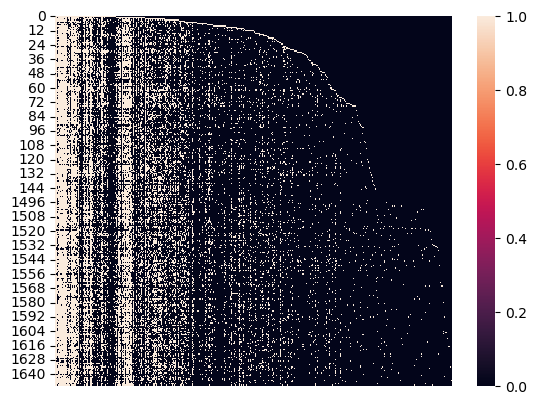

In [85]:
sns.heatmap(np.logical_and(~np.isnan(X), X != 0), xticklabels=False)

In [16]:


# Define the Frobenius norm loss function
def frobenius_norm_loss(A, B):
    return jnp.linalg.norm(A - B, 'fro')  # 'fro' specifies the Frobenius norm

# Define a function to optimize
def optimize_matrix(target_matrix, num_steps=100, learning_rate=0.1):
    # Initialize a random matrix as the initial guess
    initial_guess = jnp.array(jax.random.normal(jax.random.PRNGKey(0), target_matrix.shape))

    # Define the update function
    def update(step, grads, opt_state):
        loss = frobenius_norm_loss(target_matrix, get_params(opt_state))
        grads = grad(frobenius_norm_loss)(get_params(opt_state), target_matrix)
        return optimizer_update(step, grads, opt_state)

    # Initialize the optimizer
    optimizer_init, optimizer_update, get_params = adam(learning_rate)

    # Create an optimizer instance
    opt_state = optimizer_init(initial_guess)

    # Perform optimization
    for step in range(num_steps):
        grads = grad(frobenius_norm_loss)(get_params(opt_state), target_matrix)
        opt_state = update(step, grads, opt_state)
    
    return get_params(opt_state)


In [17]:
# Define a target matrix that we want to approximate
target_matrix = jnp.array([[1.0, 2.0], [3.0, 4.0]])

# Optimize a matrix to approximate the target
optimized_matrix = optimize_matrix(target_matrix)

# Print the result
print("Target Matrix:")
print(target_matrix)
print("Optimized Matrix:")
print(optimized_matrix)


Target Matrix:
[[1. 2.]
 [3. 4.]]
Optimized Matrix:
[[1.0038269 2.0126803]
 [3.0059664 4.0137844]]


# Run ML

In [89]:
study_test = [study_names[-1]]
study_train = study_names[:-1]

In [95]:
data_train = crc[crc['study_name'].isin(study_train)]
data_test = crc[crc['study_name'].isin(study_test)]

X_train = data_train.iloc[:, 4:].values
X_test = data_test.iloc[:, 4:].values
y_train = data_train.iloc[:, 2] == "CRC"
y_test = data_test.iloc[:, 2] == "CRC"

In [96]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(275, 754)
(60, 754)
(275,)
(60,)


In [135]:
# Run PCA
p = 100

X_train_sd = StandardScaler().fit_transform(X_train)
X_train_pca = PCA(n_components=p)
X_train_pca.fit(X_train_sd)
X_train = X_train_pca.transform(X_train_sd)

In [141]:
# Logstic
model = LogisticRegression()
model.fit(X_train, y_train)

X_test_sd = StandardScaler().fit_transform(X_test)
X_test = X_train_pca.transform(X_test_sd)
y_pred = model.predict(X_test)

loss = zero_one_loss(y_pred, y_test)

print("0-1 loss of the test set:", loss)

0-1 loss of the test set: 0.4833333333333333


In [127]:
X_test.shape

(60, 100)

In [132]:
X_test_sd.shape

(60, 100)

In [ ]:
# # Load the RDA file
# robjects.r['load'](FP_CRC)

# # Convert the R data frame to a Pandas data frame
# r_dataframe = robjects.r['se']
# pandas_dataframe = pd.DataFrame(dict(zip(r_dataframe.names, list(r_dataframe))))

# # Use the Pandas data frame in Python
# print(pandas_dataframe.head())